# Sentinel-2 Wildfire Change Detection (S2-WCD)
The dataset covers 26 significant wildfire events from January 2021 to September 2023 in countries such as Australia, France, Greece, Italy, Portugal, and Spain, ensuring diverse geographical representation. By providing high-quality, accurately labeled data, S2-WCD facilitates the training of deep learning models, improving the accuracy and reliability of wildfire damage assessment. 


Available on IEEE Data Port.

Cite as: Dimitris Valsamis, Alexandros Oikonomidis, Chrysoula Chatzichristaki, Anastasia Moumtzidou, Ilias Gialampoukidis, Stefanos Vrochidis, Ioannis Kompatsiaris, "Sentinel-2 Wildfire Change Detection (S2-WCD)", IEEE Dataport, December 6, 2024, doi:10.21227/2t8j-t191

In [1]:
# utilities functions
import os, glob, re
from datetime import datetime

import numpy as np
import pandas as pd 
import geopandas as gpd
from shapely.geometry import box
import rasterio
import matplotlib.pyplot as plt

RGB_BANDS = ["B04", "B03", "B02"]

def _stretch(x, p=(2, 98)):
    lo, hi = np.percentile(x, p)
    return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)

def read_rgb(src):
    if os.path.isdir(src):
        bands, shapes = [], []
        for b in RGB_BANDS:
            tif = glob.glob(os.path.join(src, f"*_{b}.tif"))[0]
            with rasterio.open(tif) as ds:
                arr = ds.read(1).astype("float32") / 10_000.0
            bands.append(arr);  shapes.append(arr.shape)
        if len(set(shapes)) != 1:
            raise ValueError(f"Band shapes differ in {src}: {shapes}")
        rgb = np.stack([_stretch(b) for b in bands], axis=-1)
    else:                                                        
        with rasterio.open(src) as ds:
            arr = ds.read([1, 2, 3]).astype("float32")
        rgb = np.stack([_stretch(b) for b in arr], axis=-1)
    return rgb.astype("float32")

def read_mask(path):
    with rasterio.open(path) as ds:
        return ds.read(1)

def locate_rgb_source(parent, stem):
    folder = os.path.join(parent, stem)
    if os.path.isdir(folder):
        return folder
    mb_file = os.path.join(parent, f"{stem}.tif")
    if os.path.exists(mb_file):
        return mb_file
    raise FileNotFoundError(f"{stem} not found in {parent}")

def show_triplet(pre, post, mask, title):
    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    ax[0].imshow(pre);  ax[0].set_title("Pre-event");   ax[0].axis("off")
    ax[1].imshow(post); ax[1].set_title("Post-event");  ax[1].axis("off")
    ax[2].imshow(mask, cmap="Reds"); ax[2].set_title("Burn Scar mask"); ax[2].axis("off")
    fig.suptitle(title, fontsize=14);  plt.tight_layout();  plt.show()


def plot_grid(root, locations=None, max_rows=None, fig_width=12):
    """
    # show datasets in a grid layout instead of one by one
    root       : directory containing all location folders
    locations  : iterable of folder names to plot (default = all)
    max_rows   : the number of rows 
    fig_width  : overall figure width in inches
    """
    if locations is None:
        locations = sorted([d for d in os.listdir(root)
                            if os.path.isdir(os.path.join(root, d))])
    if max_rows:
        locations = locations[:max_rows]

    n_rows, n_cols = len(locations), 3
    fig_height = fig_width / n_cols * n_rows 
    fig, ax = plt.subplots(n_rows, n_cols,
                           figsize=(fig_width, fig_height),
                           squeeze=False)

    col_titles = ["Pre-event", "Post-event", "Burn Scar Mask"]
    for j, t in enumerate(col_titles):
        ax[0, j].set_title(t, fontsize=12)

    for i, loc in enumerate(locations):
        loc_dir = os.path.join(root, loc)
        try:
            pre_src  = locate_rgb_source(loc_dir, "img1_cropped")
            post_src = locate_rgb_source(loc_dir, "img2_cropped")
            cm_tif   = glob.glob(os.path.join(loc_dir, "cm", "*.tif"))[0]
        except (FileNotFoundError, IndexError) as e:
            print(f"[skip] {loc}: {e}")
            continue

        pre  = read_rgb(pre_src)
        post = read_rgb(post_src)
        mask = read_mask(cm_tif)

        ax[i, 0].imshow(pre)
        ax[i, 1].imshow(post)
        ax[i, 2].imshow(mask, cmap="Reds")

        for j in range(n_cols):
            ax[i, j].axis("off")
        # row label on the left
        ax[i, 0].set_ylabel(loc, rotation=0, labelpad=40,
                            va="center", fontsize=11)

    plt.tight_layout()
    plt.show()


def extract_date_band_from_filename(filename):
    """
    Extract date and band (e.g., 'B04') from Sentinel-style filename.
    Example: T30TWL_20220727T105629_B04.tif → ('2022-07-27', 'B04')
    """
    match = re.search(r"_(\d{8})T\d+_(B\d{2,2}[A]?)\.tif", filename)
    if match:
        date_str = match.group(1)
        band = match.group(2)
        date = datetime.strptime(date_str, "%Y%m%d").date()
        return date, band
    return None, None

def extract_geometry_from_tif(tif_path):
    with rasterio.open(tif_path) as src:
        bounds = src.bounds
        crs = src.crs
        geom = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        return geom, crs
    
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.ops import unary_union
import numpy as np

def extract_geometry_from_mask_tif(tif_path, burn_value=1, simplify_tolerance=None):
    """
    Extracts burn area geometry from a binary fire mask raster.

    Parameters:
    - tif_path: str, path to the fire mask .tif file.
    - burn_value: int or list, pixel value(s) considered as burned (default=1).
    - simplify_tolerance: float, if set, simplifies geometry by given tolerance.

    Returns:
    - burn_geom: shapely.geometry (Polygon or MultiPolygon)
    - crs: rasterio.crs.CRS object
    """
    with rasterio.open(tif_path) as src:
        mask = src.read(1)
        crs = src.crs
        transform = src.transform

        # Create binary mask
        if isinstance(burn_value, (list, tuple, set)):
            mask_bin = np.isin(mask, list(burn_value)).astype("uint8")
        else:
            mask_bin = (mask == burn_value).astype("uint8")

        results = shapes(mask_bin, mask=mask_bin, transform=transform)

        # Extract geometries
        geoms = [shape(geom) for geom, value in results if value == 1]

        if not geoms:
            return None, crs

        # Union all parts
        burn_geom = unary_union(geoms)

        # Simplify if requested
        if simplify_tolerance:
            burn_geom = burn_geom.simplify(simplify_tolerance)

        return burn_geom, crs



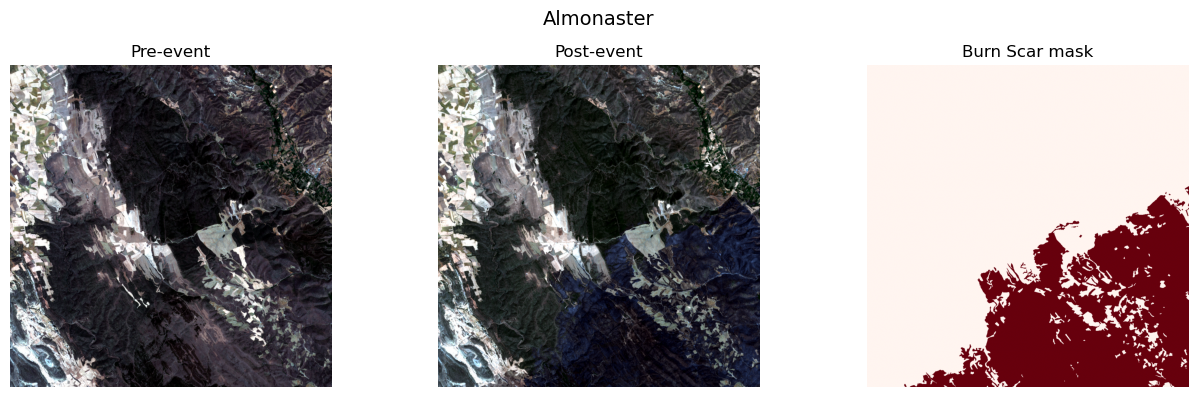

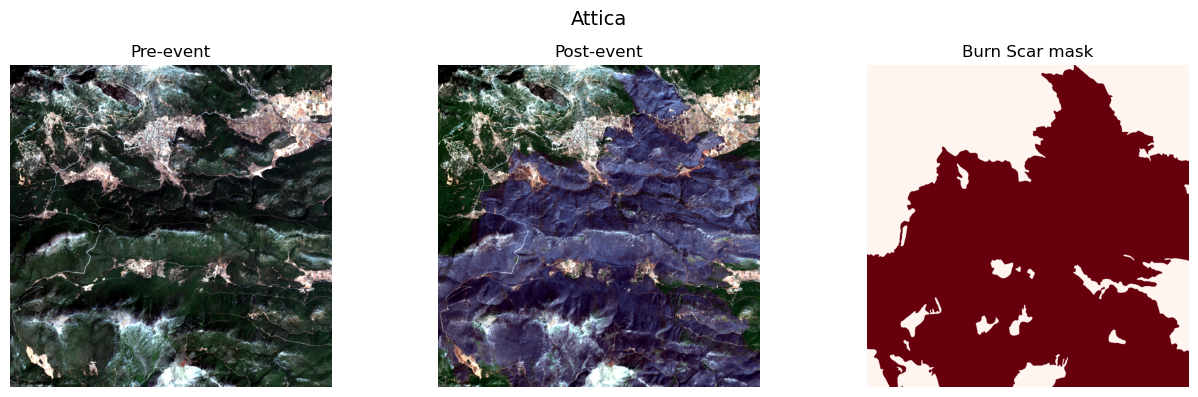

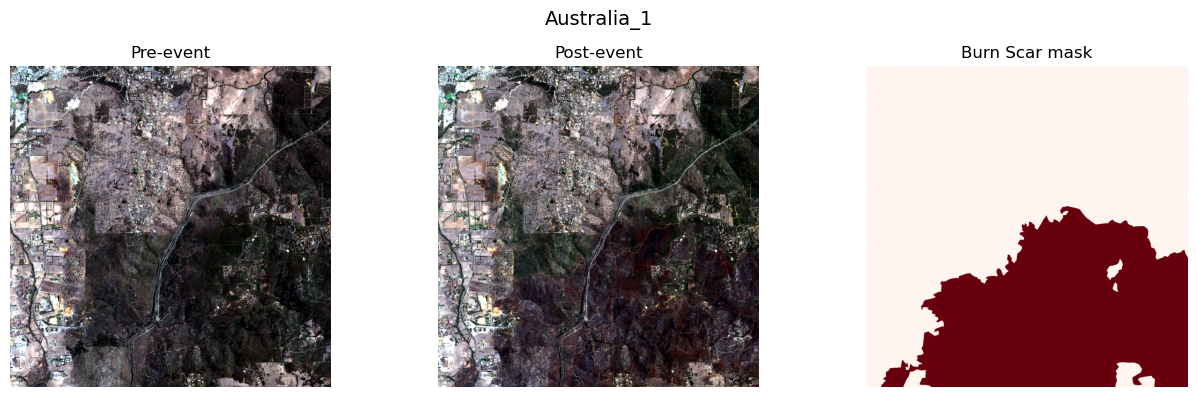

In [2]:
root = "/workspace/Rufai/data/S2-WCD/" 
count = 0
MAX = 3

for loc in sorted(os.listdir(root)):
    loc_dir = os.path.join(root, loc)
    if not os.path.isdir(loc_dir):
        continue
    try:
        pre_src  = locate_rgb_source(loc_dir, "img1_cropped")
        post_src = locate_rgb_source(loc_dir, "img2_cropped")
        cm_tif   = glob.glob(os.path.join(loc_dir, "cm", "*.tif"))[0]  # cm is a file
    except (FileNotFoundError, IndexError) as e:
        print(e);  continue

    pre  = read_rgb(pre_src)
    post = read_rgb(post_src)
    mask = read_mask(cm_tif)

    show_triplet(pre, post, mask, title=loc)

    count += 1
    if count >= MAX:
        break


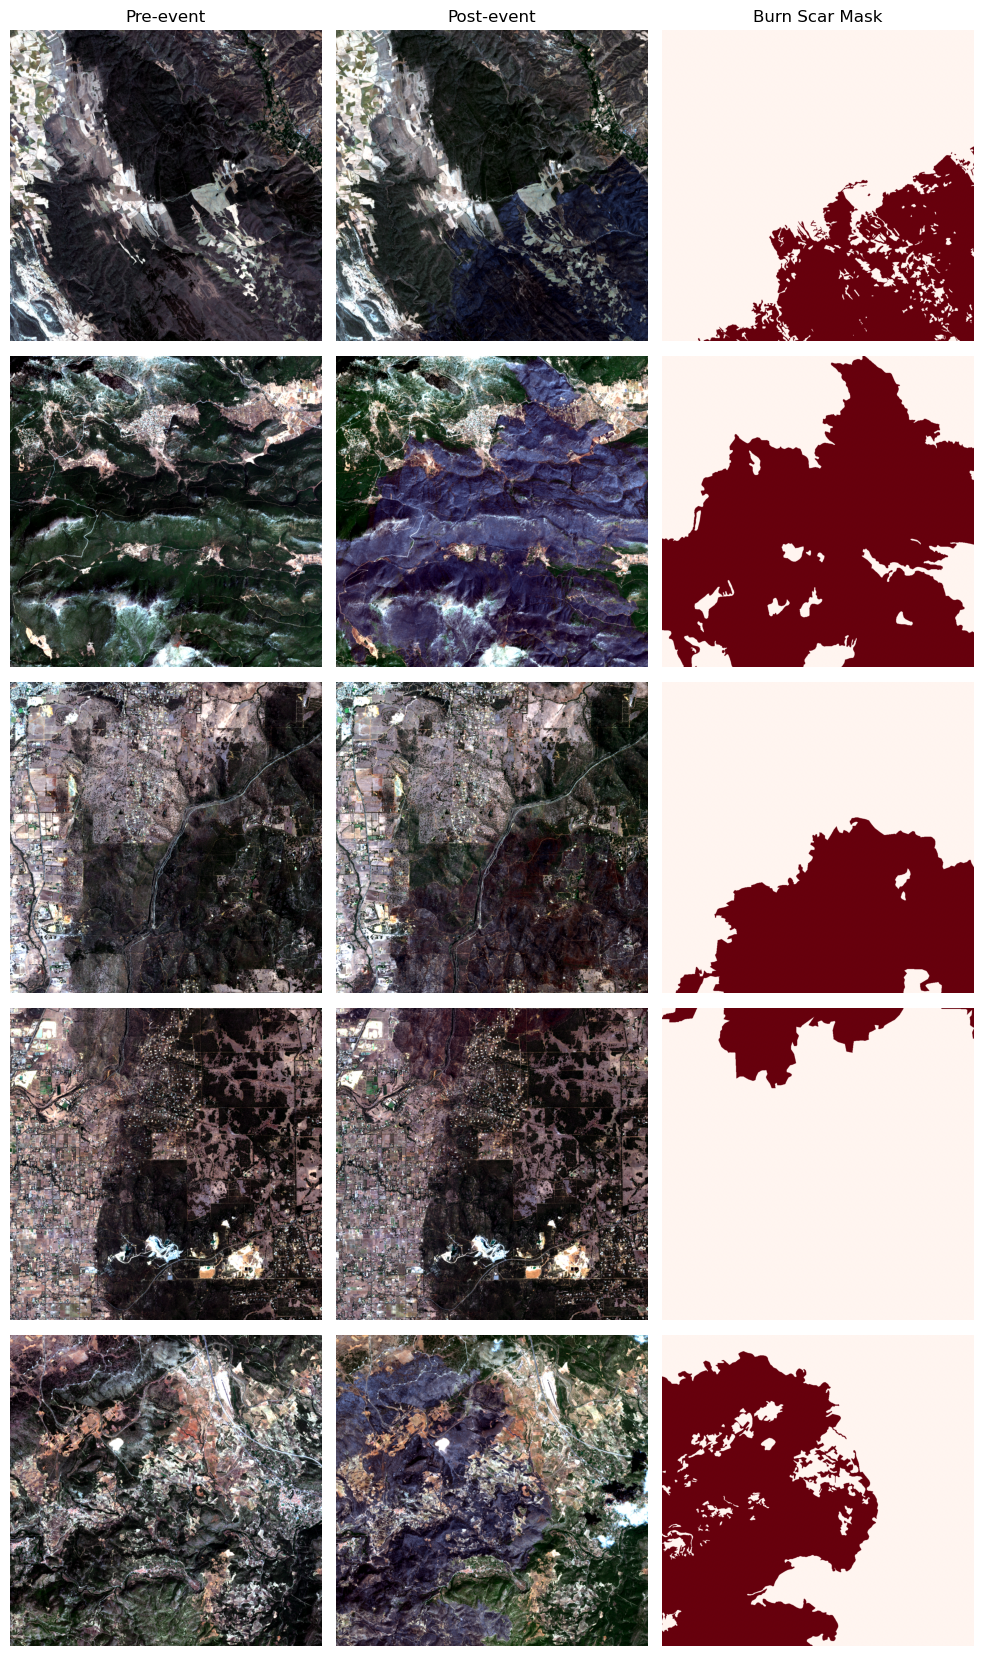

In [3]:
root_dir = "/workspace/Rufai/data/S2-WCD/" 
plot_grid(root_dir, max_rows=5, fig_width=10)

In [4]:
root = "/workspace/Rufai/data/S2-WCD/"
records = []
location_geoms = {}

for loc in sorted(os.listdir(root)):
    loc_dir = os.path.join(root, loc)
    if not os.path.isdir(loc_dir):
        continue

    try:
        pre_dir = os.path.join(loc_dir, "img1_cropped")
        mask_dir = os.path.join(loc_dir, "cm")
        mask_path = glob.glob(os.path.join(mask_dir, "cm.tif"))[0]
        geom, crs = extract_geometry_from_mask_tif(mask_path, burn_value=1, simplify_tolerance=None)
        location_geoms[loc] = {"geometry": geom, "crs": crs}
    except Exception as e:
        print(f"[geometry skipped] {loc}: {e}")
        continue

    # Pre-event bands
    if os.path.isdir(pre_dir):
        for tif in glob.glob(os.path.join(pre_dir, "*.tif")):
            date, band = extract_date_band_from_filename(os.path.basename(tif))
            if date and band:
                records.append({
                    "location": loc,
                    "event_type": "pre",
                    "band": band,
                    "date": date,
                    "path": tif
                })

    # Post-event bands
    post_dir = os.path.join(loc_dir, "img2_cropped")
    if os.path.isdir(post_dir):
        for tif in glob.glob(os.path.join(post_dir, "*.tif")):
            date, band = extract_date_band_from_filename(os.path.basename(tif))
            if date and band:
                records.append({
                    "location": loc,
                    "event_type": "post",
                    "band": band,
                    "date": date,
                    "path": tif
                })

    # wildfire mask
    for cm_path in glob.glob(os.path.join(loc_dir, "cm", "*.tif")):
        records.append({
            "location": loc,
            "event_type": "mask",
            "band": None,
            "date": None,
            "path": cm_path
        })

df = pd.DataFrame(records)
loc_df = pd.DataFrame([
    {"location": loc, "geometry": v["geometry"]}
    for loc, v in location_geoms.items()
])
gdf = gpd.GeoDataFrame(loc_df, geometry="geometry", crs=next(iter(location_geoms.values()))["crs"])
gdf = gdf.to_crs("EPSG:4326")

df = df.merge(gdf, on="location", how="left")
df_reduced = df.drop(columns=["band"])
df_unique = (
    df_reduced
    .drop_duplicates(subset=["location", "event_type"])
    .reset_index(drop=True)
)

# Save CSV with WKT-encoded geometry
df_unique["geometry"] = df_unique["geometry"].apply(lambda g: g.wkt if g else None)
df_unique.head(10)

location event_type        date  \
0   Almonaster        pre  2022-07-12   
1   Almonaster       post  2022-07-27   
2   Almonaster       mask        None   
3       Attica        pre  2021-08-16   
4       Attica       post  2021-08-28   
5       Attica       mask        None   
6  Australia_1        pre  2021-01-31   
7  Australia_1       post  2021-02-20   
8  Australia_1       mask        None   
9  Australia_2        pre  2021-01-31   

                                                path  \
0  /workspace/Rufai/data/S2-WCD/Almonaster/img1_c...   
1  /workspace/Rufai/data/S2-WCD/Almonaster/img2_c...   
2  /workspace/Rufai/data/S2-WCD/Almonaster/cm/cm.tif   
3  /workspace/Rufai/data/S2-WCD/Attica/img1_cropp...   
4  /workspace/Rufai/data/S2-WCD/Attica/img2_cropp...   
5      /workspace/Rufai/data/S2-WCD/Attica/cm/cm.tif   
6  /workspace/Rufai/data/S2-WCD/Australia_1/img1_...   
7  /workspace/Rufai/data/S2-WCD/Australia_1/img2_...   
8  /workspace/Rufai/data/S2-WCD/Australia_1/cm/cm...   
9  /workspace/Rufai/data/S2-WCD/Australia_2/img1_...   

                                            geometry  
0  MULTIPOLYGON (((-1.9465144286373106 41.3722766...  
1  MULTIPOLYGON (((-1.9465144286373106 41.3722766...  
2  MULTIPOLYGON (((-1.9465144286373106 41.3722766...  
3  MULTIPOLYGON (((-0.7064004420359428 38.0931080...  
4  MULTIPOLYGON (((-0.7064004420359428 38.0931080...  
5  MULTIPOLYGON (((-0.7064004420359428 38.0931080...  
6  POLYGON ((-4.4726378685308 58.56369227780322, ...  
7  POLYGON ((-4.4726378685308 58.56369227780322, ...  
8  POLYGON ((-4.4726378685308 58.56369227780322, ...  
9  MULTIPOLYGON (((-4.494788559093 58.50657608358...

In [5]:
df_unique.to_csv("../data/s2_wcd_fires.csv", index=False)

In [6]:
# # df.to_csv("../data/s2_wcd_fires.csv")
# gdf_full = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
# gdf_full.to_file("../data/s2_wcd_fires.geojson", driver="GeoJSON")

In [7]:
# minimal_gdf = gpd.GeoDataFrame(
#     [{"location": loc, "geometry": v["geometry"]} for loc, v in location_geoms.items()],
#     geometry="geometry",
#     crs=next(iter(location_geoms.values()))["crs"]
# )

# # Reproject to WGS 84
# minimal_gdf = minimal_gdf.to_crs("EPSG:4326")
# # Save as GeoJSON
# minimal_gdf.to_file("wildfire_locations.geojson", driver="GeoJSON")